#DATA PREPROCESSING

In [4]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


data = pd.read_csv("/content/reddit_fastfood_data.csv")
df = pd.DataFrame(data)

print("=== ORIGINAL DATA (FIRST 3 ROWS) ===")
print(df.head(3))
print("\n" + "="*80 + "\n")

## 1. Basic Cleaning
def basic_clean(text):
    if not isinstance(text, str):
        return ""

    # Remove weird encoding artifacts first
    text = re.sub(r'Ã¢Å“â€¦Ã¯Â¸Â', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII chars

    # Standard cleaning
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # URLs
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Special chars/numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Extra whitespace
    return text

df['cleaned_text'] = df['post'].apply(basic_clean)

print("=== AFTER BASIC CLEANING ===")
print("Example 1 - Before:", df['post'][1])
print("Example 1 - After:", df['cleaned_text'][1])
print("\nExample 2 - Before:", df['post'][5])
print("Example 2 - After:", df['cleaned_text'][5])
print("\nDataFrame Preview:")
print(df[['post', 'cleaned_text']].head(3))
print("\n" + "="*80 + "\n")

## 2. Advanced Normalization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def advanced_normalization(text):
    # Custom additions for social media text
    custom_stopwords = {'lol', 'lmao', 'stahp','ahh'}
    stop_words.update(custom_stopwords)

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['normalized_text'] = df['cleaned_text'].apply(advanced_normalization)

print("=== AFTER NORMALIZATION ===")
print("Example 1 - Before:", df['cleaned_text'][0])
print("Example 1 - After:", df['normalized_text'][0])
print("\nExample 2 - Before:", df['cleaned_text'][3])
print("Example 2 - After:", df['normalized_text'][3])
print("\nDataFrame Preview:")
print(df[['cleaned_text', 'normalized_text']].head(3))
print("\n" + "="*80 + "\n")

## 3. Brand-Specific Processing
def handle_brand_context(text, brand):
    text = re.sub(r'burger\s*king', 'brandtoken', text)
    text = re.sub(r'bk\s', 'brandtoken ', text)
    return text

df['brand_processed'] = df.apply(lambda x: handle_brand_context(x['normalized_text'], x['Brand']), axis=1)

print("=== AFTER BRAND PROCESSING ===")
print("Example - Before:", df['normalized_text'][2])
print("Example - After:", df['brand_processed'][2])
print("\nDataFrame Preview:")
print(df[['normalized_text', 'brand_processed']].head(3))
print("\n" + "="*80 + "\n")

## 4. Sentiment-Specific Processing
def sentiment_specific_processing(text):
    # Handle negations
    negation_words = ['not', 'no', 'never', 'dont']
    tokens = text.split()

    for i, word in enumerate(tokens):
        if word in negation_words and i+1 < len(tokens):
            tokens[i+1] = 'NOT_' + tokens[i+1]

    # Handle intensifiers
    intensifiers = {'very', 'really', 'extremely'}
    for i, word in enumerate(tokens):
        if word in intensifiers and i+1 < len(tokens):
            tokens[i+1] = 'INTENSE_' + tokens[i+1]

    return ' '.join(tokens)

df['sentiment_ready'] = df['brand_processed'].apply(sentiment_specific_processing)

print("=== AFTER SENTIMENT PROCESSING ===")
print("Example 1 (Negative) - Before:", df['brand_processed'][0])
print("Example 1 - After:", df['sentiment_ready'][0])
print("\nExample 2 (Positive) - Before:", df['brand_processed'][5])
print("Example 2 - After:", df['sentiment_ready'][5])
print("\nDataFrame Preview:")
print(df[['brand_processed', 'sentiment_ready']].head(3))
print("\n" + "="*80 + "\n")

## 5. Final Output
print("=== FINAL PROCESSED DATA ===")
print(df[['Brand', 'post', 'sentiment_ready', 'Sentiment']].head(6))

# Save to CSV
df.to_csv('preprocessed_data.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


=== ORIGINAL DATA (FIRST 3 ROWS) ===
   share_count  upvote_count Sentiment       Brand location  \
0            5            13  positive  McDonald's      USA   
1            4             7  negative   Pizza Hut       UK   
2            5             9  positive      Subway      USA   

                                                post  polarity_Score  \
0  McDonald's never disappoints. The service was ...             0.6   
1  Worst service at Pizza Hut today. Waited 45 mi...            -0.8   
2  Best Subway meal I've had in years. 10/10 woul...             1.0   

         created_at  
0  09-08-2024 00:26  
1  27-07-2024 06:10  
2  13-09-2024 11:17  


=== AFTER BASIC CLEANING ===
Example 1 - Before: Worst service at Pizza Hut today. Waited 45 minutes for cold fries.
Example 1 - After: worst service at pizza hut today waited minutes for cold fries

Example 2 - Before: Horrible experience at Subway yesterday. Food was cold and staff was rude. @stewartandrew
Example 2 - After: ho

#1.SENTIMENT ANALYSIS

In [1]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

VADER SENTIMENT ANALYSIS

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader_analyzer = SentimentIntensityAnalyzer()
df=pd.read_csv('/content/preprocessed_data.csv')
#VADER SENTIMENT SCORES
df['vader_scores'] = df['post'].apply(lambda x: vader_analyzer.polarity_scores(x))

vader_df = pd.json_normalize(df['vader_scores'])
df = pd.concat([df, vader_df], axis=1)
df.drop(columns=['vader_scores'], inplace=True)

df['vader_sentiment'] = df['compound'].apply(
    lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral')
)

df[['post', 'compound', 'vader_sentiment']].head()


,post,compound,vader_sentiment
0,McDonald's never disappoints. The service was ...,0.7170,positive
1,Worst service at Pizza Hut today. Waited 45 mi...,-0.6249,negative
2,Best Subway meal I've had in years. 10/10 woul...,0.7901,positive
3,The McDonald's at pizza is my favorite. Always...,0.6486,positive
4,Love the new KFC burger! So juicy and flavorfu...,0.6696,positive


TEXTBLOB SENTIMENT ANALYSIS

In [8]:
from textblob import TextBlob

df['textblob_polarity'] = df['post'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['textblob_subjectivity'] = df['post'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

def get_textblob_sentiment(polarity):
    if polarity > 0.05:
        return 'positive'
    elif polarity < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['textblob_sentiment'] = df['textblob_polarity'].apply(get_textblob_sentiment)
df[['post', 'textblob_polarity', 'textblob_subjectivity', 'textblob_sentiment']].head()


,post,textblob_polarity,textblob_subjectivity,textblob_sentiment
0,McDonald's never disappoints. The service was ...,0.600000,0.900000,positive
1,Worst service at Pizza Hut today. Waited 45 mi...,-0.800000,1.000000,negative
2,Best Subway meal I've had in years. 10/10 woul...,1.000000,0.300000,positive
3,The McDonald's at pizza is my favorite. Always...,0.400000,0.750000,positive
4,Love the new KFC burger! So juicy and flavorfu...,0.335227,0.527273,positive


Comparing VADER and TextBlob

In [9]:
df['sentiment_match'] = df.apply(
    lambda row: 'match' if row['textblob_sentiment'] == row['vader_sentiment'] else 'mismatch',
    axis=1
)

match_counts = df['sentiment_match'].value_counts()
print("Match vs Mismatch Count:\n", match_counts)
comparison_matrix = pd.crosstab(
    df['textblob_sentiment'],
    df['vader_sentiment'],
    rownames=['TextBlob'],
    colnames=['VADER'],
    margins=True
)
print("\nSentiment Comparison Matrix:\n", comparison_matrix)


Match vs Mismatch Count:
 sentiment_match
match       6079
mismatch    2540
Name: count, dtype: int64

Sentiment Comparison Matrix:
 VADER     negative  neutral  positive   All
TextBlob                                   
negative      1966      639         0  2605
neutral        632        0         0   632
positive       606      663      4113  5382
All           3204     1302      4113  8619


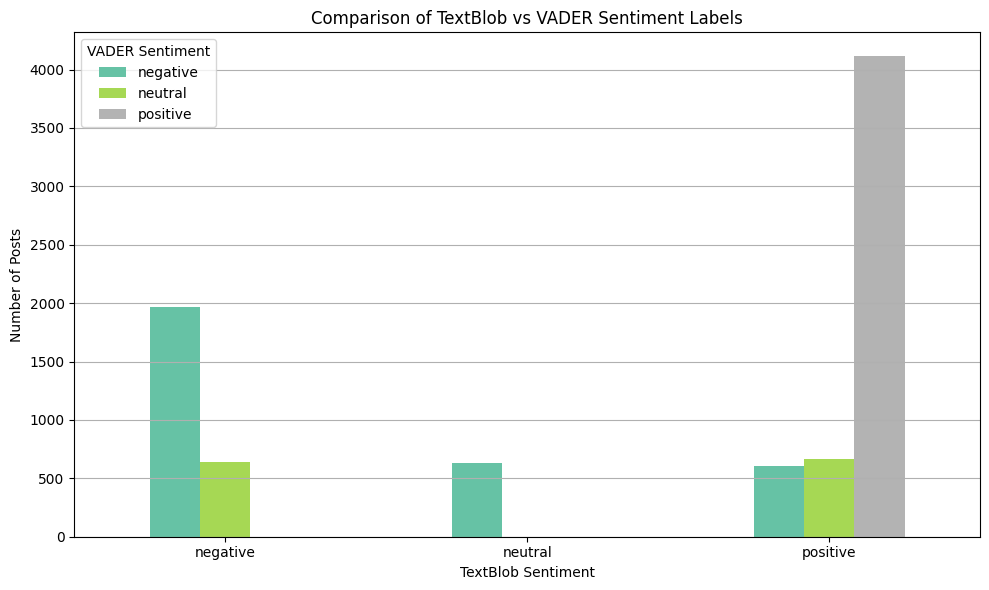

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_crosstab = pd.crosstab(df['textblob_sentiment'], df['vader_sentiment'])

sentiment_crosstab.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title('Comparison of TextBlob vs VADER Sentiment Labels')
plt.xlabel('TextBlob Sentiment')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)
plt.legend(title='VADER Sentiment')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


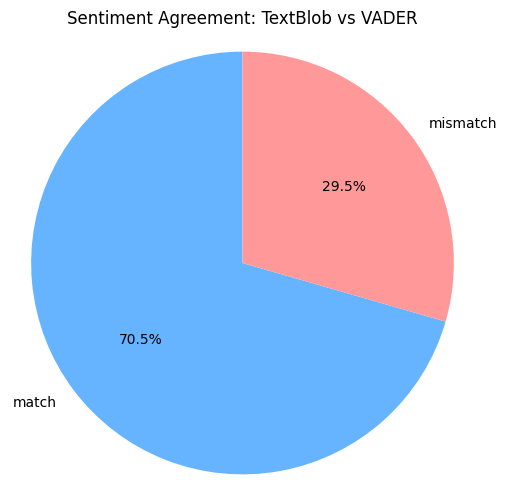

In [12]:
match_counts = df['sentiment_match'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(match_counts, labels=match_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Sentiment Agreement: TextBlob vs VADER')
plt.axis('equal')
plt.show()


#2.HASHTAG ANALYSIS

Regex Hashtag Extraction

In [16]:
import re

df['hashtags'] = df['post'].apply(lambda x: re.findall(r"#\w+", x))
all_hashtags = [hashtag for sublist in df['hashtags'] for hashtag in sublist]
from collections import Counter
hashtag_counts = Counter(all_hashtags)

hashtag_df = pd.DataFrame(hashtag_counts.items(), columns=['Hashtag', 'Count'])
hashtag_df = hashtag_df.sort_values(by='Count', ascending=False)

hashtag_df.head(6)


,Hashtag,Count
5,#Dominos,452
1,#KFC,451
4,#PizzaHut,449
3,#Subway,420
2,#BurgerKing,419
0,#McDonalds,382


HASHTAG FREQUENCY PLOT

<ipython-input-19-88f136e78db2>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Hashtag', data=top_hashtags, palette='Set2')


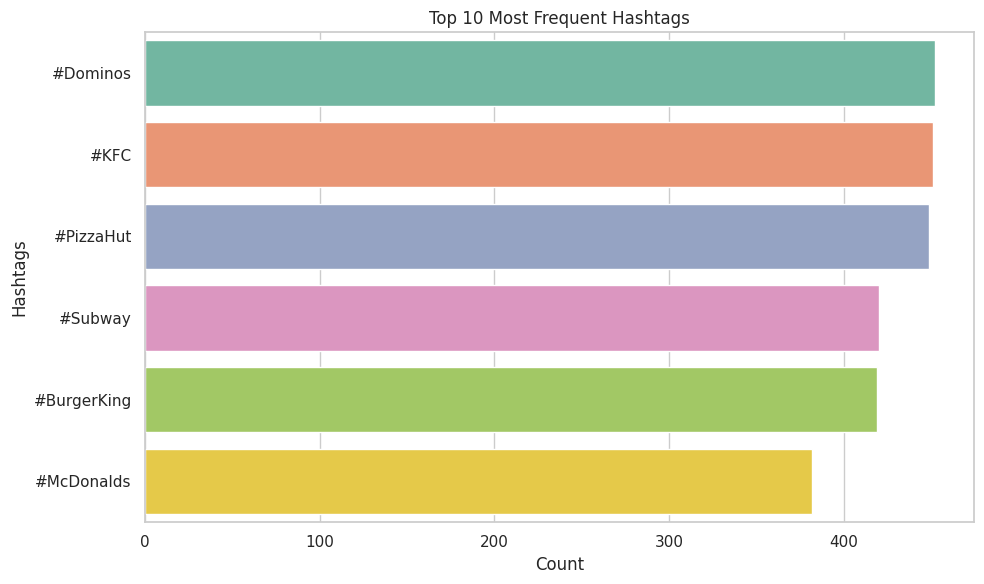

In [19]:
# Plotting the top 10 most frequent hashtags
top_hashtags = hashtag_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Hashtag', data=top_hashtags, palette='Set2')
plt.title('Top 10 Most Frequent Hashtags')
plt.xlabel('Count')
plt.ylabel('Hashtags')
plt.tight_layout()
plt.show()


WORDCLOUD

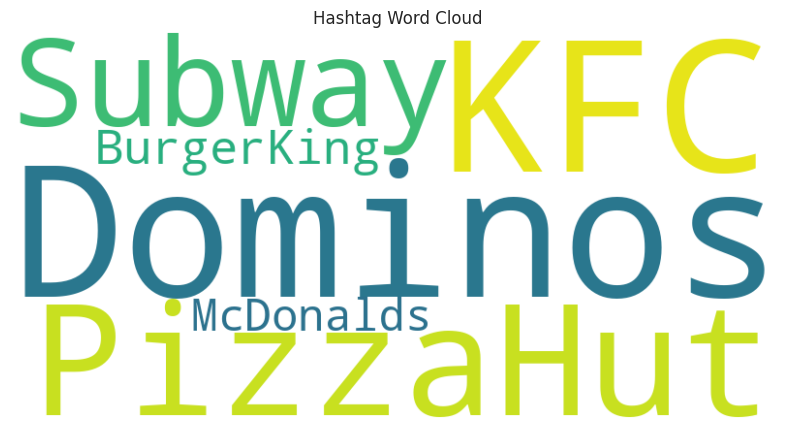

In [22]:
from wordcloud import WordCloud

hashtag_str = ' '.join(all_hashtags)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(hashtag_str)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Hashtag Word Cloud')
plt.show()


# 3.ENGAGEMENT ANALYSIS

In [25]:
df[['Brand', 'upvote_count', 'share_count', 'polarity_Score']].head()


,Brand,upvote_count,share_count,polarity_Score
0,McDonald's,13,5,0.60
1,Pizza Hut,7,4,-0.80
2,Subway,9,5,1.00
3,McDonald's,12,5,0.40
4,KFC,12,5,0.34


In [26]:
df[['upvote_count', 'share_count']] = df[['upvote_count', 'share_count']].fillna(0)
df['total_engagement'] = df['upvote_count'] + df['share_count']


In [30]:
df[['post', 'total_engagement']].sort_values(by='total_engagement', ascending=False).head()

,post,total_engagement
5024,Burger King never disappoints. The service was...,59
8033,Visited Domino's yesterday. The combo was aver...,51
5602,Ordered from KFC. Nothing special. #KFC,51
5242,Ordered from Burger King. Nothing special.,47
4793,Ordered from Subway. Nothing special. #Subway,47


 Average engagement per brand

<ipython-input-31-2c915f525e6b>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_engagement.index, y=avg_engagement.values, palette='crest')


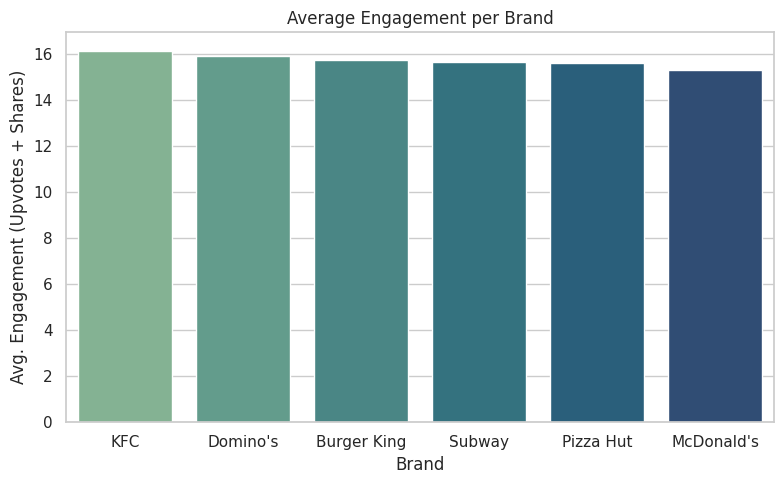

In [31]:
avg_engagement = df.groupby('Brand')['total_engagement'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=avg_engagement.index, y=avg_engagement.values, palette='crest')
plt.title('Average Engagement per Brand')
plt.ylabel('Avg. Engagement (Upvotes + Shares)')
plt.xlabel('Brand')
plt.tight_layout()
plt.show()


#4. BRAND VIRALITY ANALYSIS

Virality index 1 - Custom formula we made

<ipython-input-34-f3b2429b3f9c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=virality_by_brand.index, y=virality_by_brand.values, palette='magma')


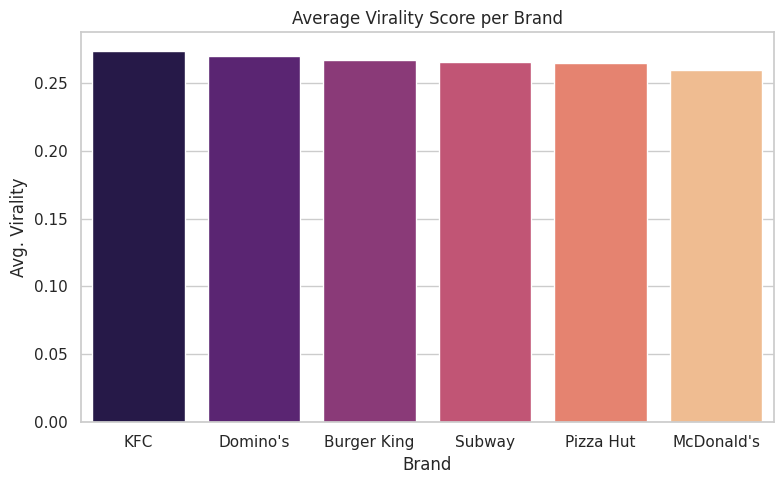

In [34]:
df['total_engagement'] = df['upvote_count'] + df['share_count']
df['virality_score'] = df['total_engagement']  / df['total_engagement'].max()

virality_by_brand = df.groupby('Brand')['virality_score'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=virality_by_brand.index, y=virality_by_brand.values, palette='magma')
plt.title('Average Virality Score per Brand')
plt.ylabel('Avg. Virality')
plt.xlabel('Brand')
plt.tight_layout()
plt.show()


Virality index 2- Emotion Weighted Formula

<ipython-input-36-1762a68c9d74>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_virality_by_brand.index, y=emotion_virality_by_brand.values, palette='coolwarm')


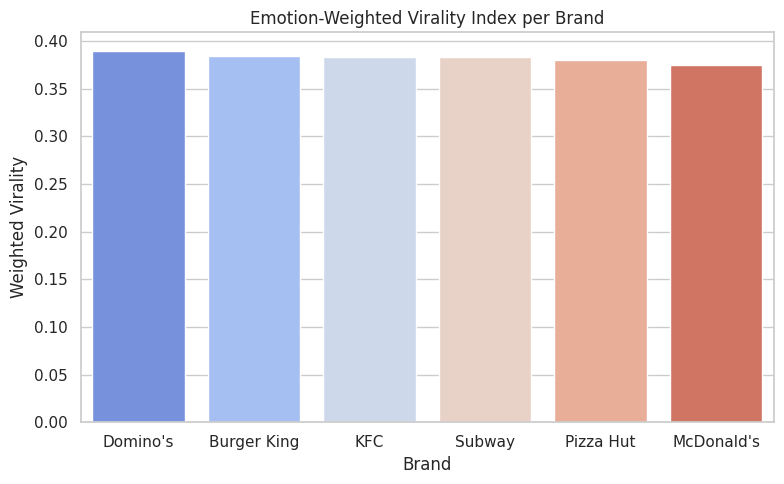

In [36]:
# Mapping sentiment polarity to sentiment class
df['sentiment_class'] = df['polarity_Score'].apply(
    lambda x: 'positive' if x > 0.05 else 'negative' if x < -0.05 else 'neutral'
)

# Mapping sentiment to numeric score
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_score'] = df['sentiment_class'].map(sentiment_map)

# Emotion amplification
df['emotion_amp'] = df['polarity_Score'] * df['sentiment_score']

df[['emotion_amp', 'upvote_count', 'share_count']] = df[[
    'emotion_amp', 'upvote_count', 'share_count']].fillna(0)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['emotion_amp', 'upvote_count', 'share_count']] = scaler.fit_transform(
    df[['emotion_amp', 'upvote_count', 'share_count']]
)

df['virality_emotion_weighted'] = (
    0.5 * df['emotion_amp'] +
    0.3 * df['upvote_count'] +
    0.2 * df['share_count']
)
emotion_virality_by_brand = df.groupby('Brand')['virality_emotion_weighted'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=emotion_virality_by_brand.index, y=emotion_virality_by_brand.values, palette='coolwarm')
plt.title('Emotion-Weighted Virality Index per Brand')
plt.ylabel('Weighted Virality')
plt.xlabel('Brand')
plt.tight_layout()
plt.show()


In [39]:
virality_comparison = df.groupby('Brand')[['virality_score', 'virality_emotion_weighted']].mean().reset_index()
virality_comparison = virality_comparison.sort_values(by='virality_score', ascending=False)

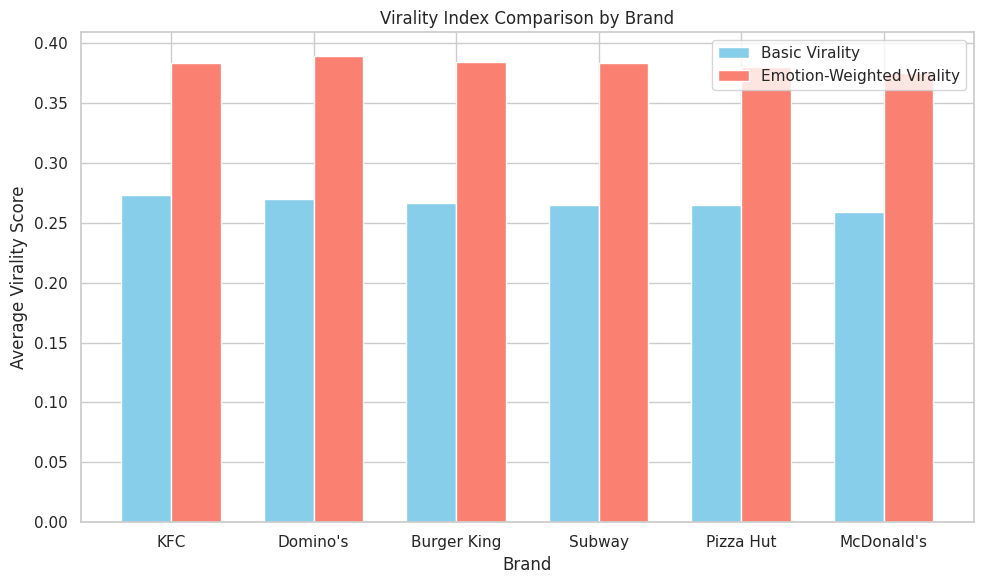

In [42]:
import numpy as np
brands = virality_comparison['Brand']
x = np.arange(len(brands))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, virality_comparison['virality_score'], width, label='Basic Virality', color='skyblue')
plt.bar(x + width/2, virality_comparison['virality_emotion_weighted'], width, label='Emotion-Weighted Virality', color='salmon')

plt.xticks(x, brands)
plt.title('Virality Index Comparison by Brand')
plt.xlabel('Brand')
plt.ylabel('Average Virality Score')
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
crisis_keywords = ['bad', 'disgusting', 'never again', 'late delivery', 'worst', 'rude', 'cold food', 'poor service']


#5.CRISIS AND COMPLAINT ANALYSIS

In [44]:
df['post_lower'] = df['post'].str.lower()
df['is_negative'] = df['polarity_Score'] < -0.05
df['is_crisis'] = df['post_lower'].apply(lambda text: any(keyword in text for keyword in crisis_keywords))

df['flagged_crisis'] = df['is_negative'] & df['is_crisis']

crisis_posts = df[df['flagged_crisis']]
crisis_posts[['Brand', 'post', 'polarity_Score']].head(10)


,Brand,post,polarity_Score
1,Pizza Hut,Worst service at Pizza Hut today. Waited 45 mi...,-0.80
5,Subway,Horrible experience at Subway yesterday. Food ...,-0.63
14,Subway,Worst service at Subway today. Waited 45 minut...,-0.80
21,Subway,Subway needs to improve their quality. This pi...,-1.00
22,KFC,Horrible experience at KFC yesterday. Food was...,-0.63
23,McDonald's,Horrible experience at McDonald's yesterday. F...,-0.63
24,Subway,Subway needs to improve their quality. This pi...,-1.00
28,Burger King,Horrible experience at Burger King yesterday. ...,-0.63
34,Burger King,Worst service at Burger King today. Waited 45 ...,-0.80
46,KFC,KFC needs to improve their quality. This burge...,-1.00


<ipython-input-45-961bb45b0492>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crisis_by_brand.index, y=crisis_by_brand.values, palette='Reds')


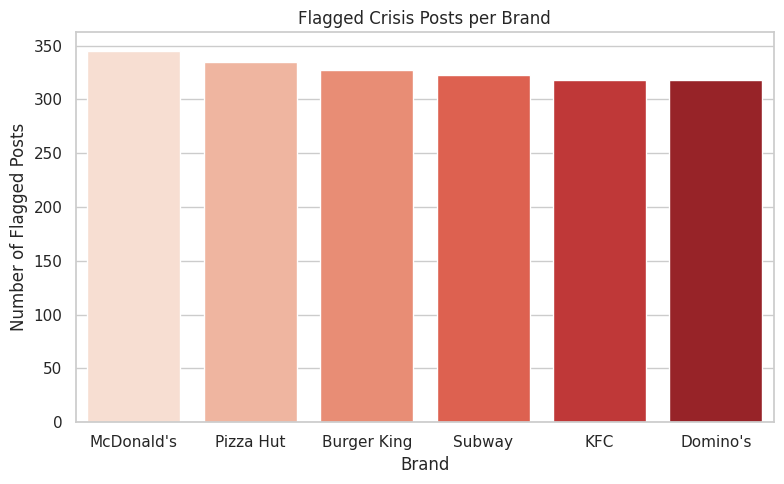

In [45]:
crisis_by_brand = crisis_posts['Brand'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=crisis_by_brand.index, y=crisis_by_brand.values, palette='Reds')
plt.title('Flagged Crisis Posts per Brand')
plt.xlabel('Brand')
plt.ylabel('Number of Flagged Posts')
plt.tight_layout()
plt.show()


In [46]:
from sklearn.feature_extraction.text import CountVectorizer

df['post_lower'] = df['post'].str.lower().fillna('')
crisis_posts = df[df['flagged_crisis']]

# Using bigrams or trigrams
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
ngrams = vectorizer.fit_transform(crisis_posts['post_lower'])

# Getting frequency of n-grams
sum_ngrams = ngrams.sum(axis=0)
ngram_freq = [(word, sum_ngrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)



worst service -> 682
today waited -> 682
waited 45 -> 682
45 minutes -> 682
minutes cold -> 682
cold fries -> 682
today waited 45 -> 682
waited 45 minutes -> 682
45 minutes cold -> 682
minutes cold fries -> 682


<ipython-input-54-dbdb84d30f56>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crisis_posts['complaint_category'] = crisis_posts['post_lower'].apply(tag_complaint_category)
<ipython-input-54-dbdb84d30f56>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='rocket')


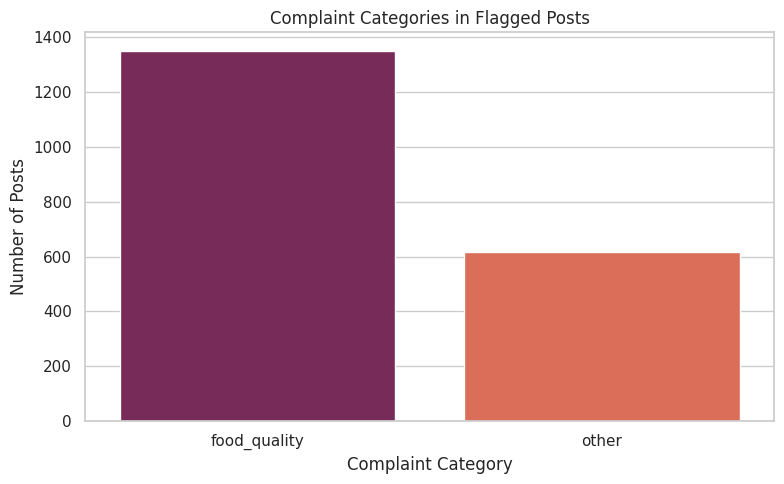

In [54]:
category_keywords = {
    'food_quality': ['cold', 'stale', 'raw', 'bad taste', 'spoiled', 'undercooked'],
    'delivery_issue': ['late', 'delay', 'never arrived', 'missing'],
    'service_issue': ['rude', 'unprofessional', 'ignored', 'bad service'],
    'cleanliness': ['dirty', 'filthy', 'unhygienic']
}

def tag_complaint_category(post):
    for category, keywords in category_keywords.items():
        if any(kw in post for kw in keywords):
            return category
    return 'other'

crisis_posts['complaint_category'] = crisis_posts['post_lower'].apply(tag_complaint_category)
category_counts = crisis_posts['complaint_category'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='rocket')
plt.title('Complaint Categories in Flagged Posts')
plt.xlabel('Complaint Category')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()


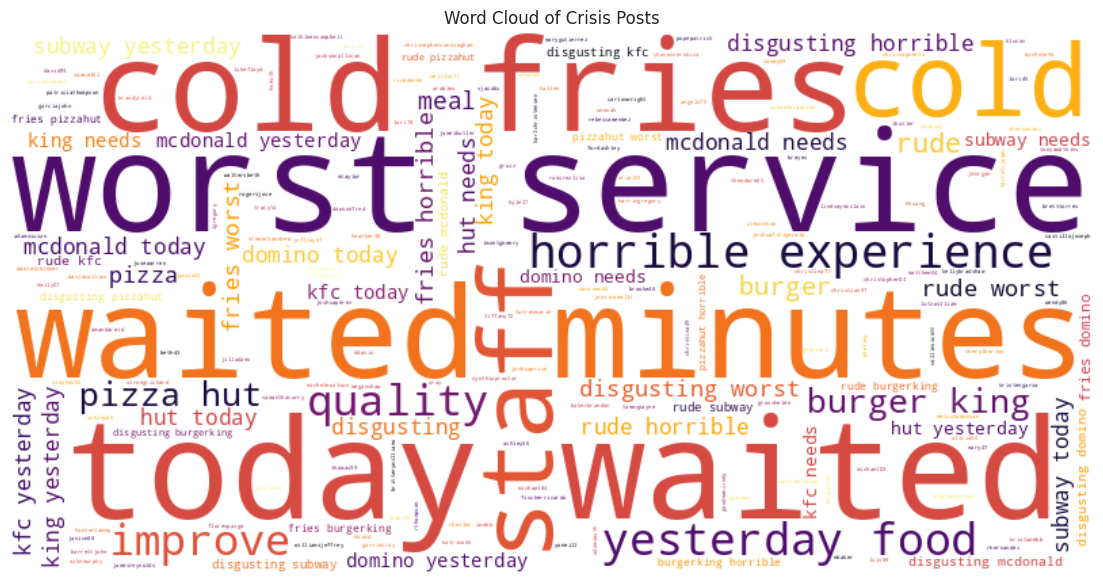

In [50]:
crisis_text = ' '.join(crisis_posts['post_lower'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='inferno').generate(crisis_text)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Crisis Posts')
plt.tight_layout()
plt.show()
